In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from BoredQiskit import FastQiskit as fq
from BoredQiskit import FastUtilsGate as fg
from BoredQiskit.FastUtilsGate import int_to_bin
import numpy as np

In [3]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

def run(qc, shots=1024):
    """
    runs the job results for a `qc` QuantumCircuit on the ideal simulator AerSimulator. 
    `shots` lets you specify how many times should the simulation run. 
    if `more_info` is set to True, it will return a dict sorted by 
    """
    sim_backend = AerSimulator(method='matrix_product_state')
    
    pm = generate_preset_pass_manager(backend=sim_backend)
    isa_qc = pm.run(qc)
    sampler = Sampler(mode=sim_backend)

    job = sampler.run([isa_qc], shots=shots)
    results = job.result()
    data = results[0].data
    counts = data.c.get_counts()

    return counts

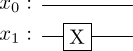

In [4]:
def encode_boolean_string(x: str):
    n = len(x)
    qx = QuantumRegister(n, 'x')
    qc = QuantumCircuit(qx)

    for c, i in enumerate(x):
        if i == '1':
            qc.x(qx[n - c - 1])
    
    return qc

encode_boolean_string('10').draw('latex')

In [5]:
def quantum_number_encode(num: int, code_len: int=0):
    """
    encodes the given `num` into a quantum circuit. if specified, `code_len` lets
    you use more qubits than needed for the number specified by `num`
    """
    if num == 0:
        return QuantumCircuit(code_len).to_gate(label=" 0 ")
        
    if code_len < int(np.ceil(np.log2(num))):
        code_len = bin_num
    bin_num = int_to_bin(num, code_len)
    qc = QuantumCircuit(code_len)
    for c, i in enumerate(bin_num):
        if i == '1':
            qc.x(code_len-1-c)
    return qc.to_gate(label=" "+str(num)+" ")

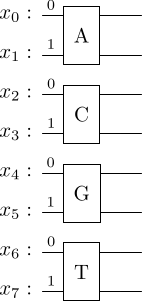

In [6]:
# A=00, C=01, G=10, T=11

def encode_dna_string(x: str):

    mapping = {
        'A': '00',
        'C': '01',
        'G': '10',
        'T': '11' 
    }

    n = len(x)
    qx = QuantumRegister(n*2, 'x')
    qc = QuantumCircuit(qx)

    for c, i in enumerate(x):
        bits = mapping[i]
        qg = QuantumCircuit(2)
        for b, j in enumerate(bits):
            if j == '1':
                qg.x(b)

        qg = qg.to_gate(label=i) 
        qc = qc.compose(qg, [c*2,c*2+1])

    return qc

encode_dna_string('ACGT').draw('latex')

In [7]:
def quantum_rotation(n: int, s: int):
    '''
    Returns a `.Gate` that implements a rotation
    of `s` positions on `n` qubits lines.
    
    Only works correctly if `s` is a power of 2. Every other
    rotation can be obtained by combination of the power of 2 rotations; so

    DONT USE THIS !!!
    '''
    qr = QuantumRegister(n, 'q')
    qc = QuantumCircuit(qr)
    
    for i in range(1, int(np.ceil(n/2))):
        qc.swap(qr[i], qr[n-i])
    
    for j in range(1, int(np.ceil(n/2))):
        qc.swap(qr[int(np.ceil(s/2))-j], qr[int(np.floor(s/2))+j])

    return qc.to_gate(label='R_'+str(s)+' ')


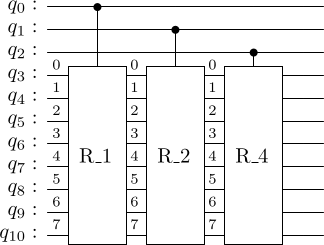

In [41]:
def quantum_controlled_rotation(n: int):
    '''
    Returns an arbitrary rotation `.Gate` on `n` qubits lines.

    page 9 of the paper
    '''
    l = int(np.ceil(np.log2(n)))

    jr = QuantumRegister(l, 'j')
    qr = QuantumRegister(n, 'q')

    qc = QuantumCircuit(jr, qr)
    for i in range(l):
        
        qc = qc.compose(quantum_rotation(n, 2**i).control(1), [i,*qr])
    return qc

qc = QuantumCircuit(11)
qc = qc.compose(quantum_controlled_rotation(8))
qc.draw('latex')


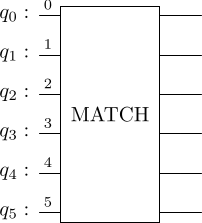

In [9]:
def match_operator(n: int):
    '''
    page 12 of the paper
    '''
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(n, 'y')
    qout = QuantumRegister(n, 'o')
    qc = QuantumCircuit(qx, qy, qout)
    
    for i in range(n):
        qc.ccx(qx[i], qy[i], qout[i])

    qc.x(qx)
    qc.x(qy)

    for i in range(n):
        qc.ccx(qx[i], qy[i], qout[i])
    
    qc.x(qx)
    qc.x(qy)
    
    return qc.to_gate(label='MATCH')

qc = QuantumCircuit(6)
qc = qc.compose(match_operator(2))#.decompose()
qc.draw('latex')

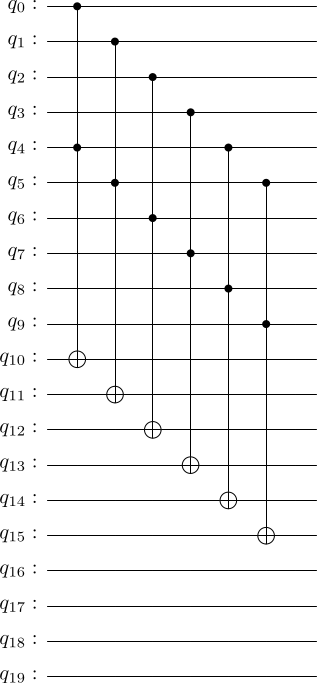

In [10]:
def extension_operator(n: int, i: int):
    '''
    page 12 of the paper
    '''
    shift = 2 ** (i - 1)

    qin = QuantumRegister(n, 'in')    
    qout = QuantumRegister(n, 'out')
    qc = QuantumCircuit(qin, qout)

    for j in range(n - shift):
        qc.ccx(qin[j], qin[j + shift], qout[j])

    return qc.to_gate(label=f'EXT_{i}')


qc = QuantumCircuit(20)
qc = qc.compose(extension_operator(10,3)).decompose()
qc.draw('latex')

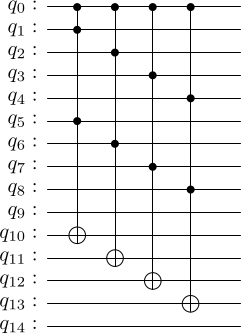

In [11]:
def contr_bitwise_and_operator(n: int):
    '''
    page 13 of the paper
    '''
    qc_ctrl = QuantumRegister(1, 'c')
    qL = QuantumRegister(n, 'L')
    qin = QuantumRegister(n+1, 'qin') # include il padding!
    qout  = QuantumRegister(n+1, 'qout')
    qc = QuantumCircuit(qc_ctrl, qL, qin, qout)

    for k in range(n):
        qc.mcx([qc_ctrl[0], qL[k], qin[k]], qout[k])

    return qc.to_gate(label="C-AND(A)")


qc = QuantumCircuit(15)
qc = qc.compose(contr_bitwise_and_operator(4)).decompose()
qc.draw('latex')

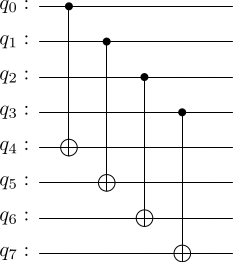

In [12]:
def copy_operator(n: int):
    '''
    page 13 of the paper
    '''
    qin = QuantumRegister(n, 'in')
    qout = QuantumRegister(n, 'out')
    qc = QuantumCircuit(qin, qout)

    for i in range(n):
        qc.cx(qin[i], qout[i])
    
    
    return qc.to_gate(label='C-COPY')


qc = QuantumCircuit(8)
qc = qc.compose(copy_operator(4)).decompose()
qc.draw('latex')

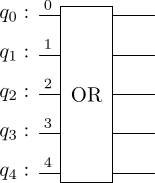

In [13]:
def or_operator(n: int):
    '''
    page 15 of the paper
    '''
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(1, 'y')
    qc = QuantumCircuit(qx, qy)
    
    qc.x(qx)
    qc.mcx(qx, qy)
    qc.x(qx)
    qc.x(qy)

    return qc.to_gate(label='OR')

qc = QuantumCircuit(5)
qc = qc.compose(or_operator(4))#.decompose()
qc.draw('latex')

In [14]:
def quantum_LCS_test():
    return False

In [15]:
X = '10111010110'
Y = '00100111010'

def quantum_LCS(x: str, y: str, n):
    l = 0
    r = n

    while l < r:
        d = np.floor((l + r) / 2)
        if quantum_LCS_test(): ## QUANTUM TEST
            l = d
        else:
            r = d - 1

    return l

print(quantum_LCS(X, Y, len(X)))

0


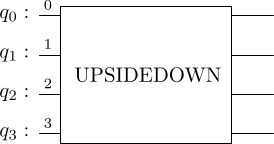

In [16]:
def updown_swap(n: int):

    qx = QuantumRegister(n, 'x')
    qc = QuantumCircuit(qx)

    for i in range(int(n/2)):
        qc.swap(i, n-i-1)
    return qc.to_gate(label=' UPSIDEDOWN')

qc = QuantumCircuit(4)
qc = qc.compose(updown_swap(4))#.decompose()
qc.draw('latex')

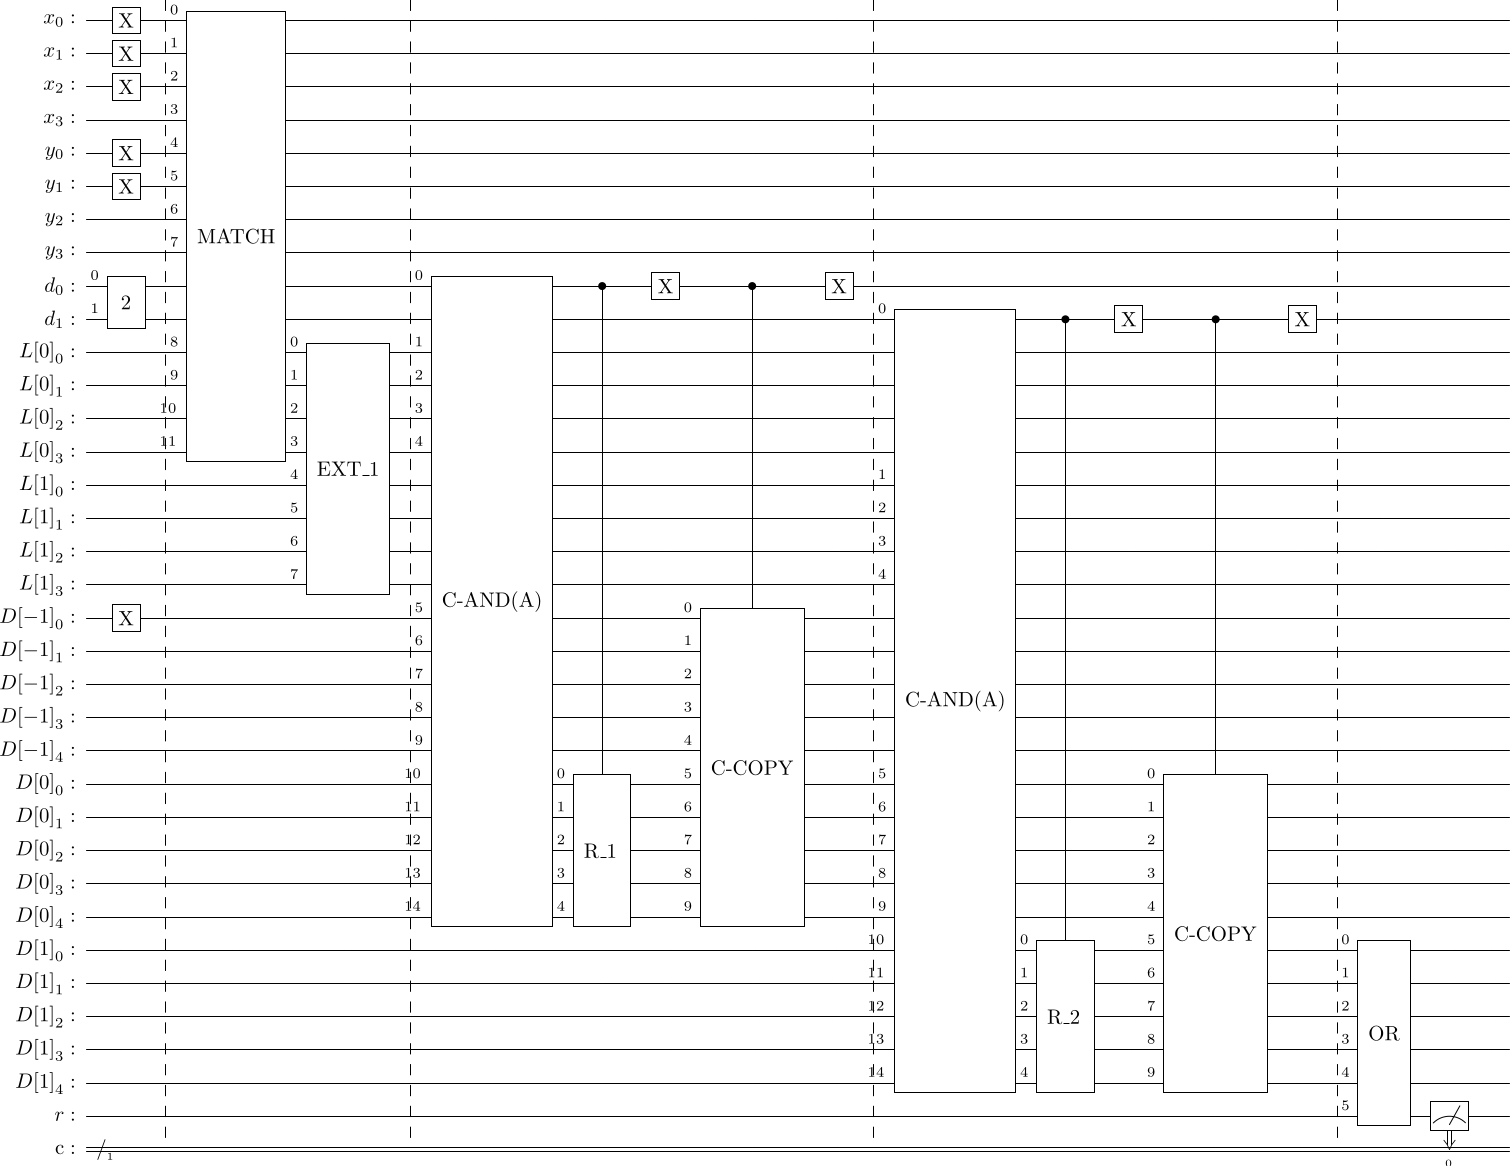

In [17]:
def FSM(n, D=0, d=0):
    '''
    builds the Fixed Substring Matching operator for inputs of size `n`

    QUBITS NEEDED:
    - `n` qubits for string x
    - `n` qubits for string y
    - `log_2(n)` qubits for string d
    - ancilla qubits
    - 1 result qubit
    '''
    d_len = int(np.ceil(np.log2(n)))
    L_num = d_len
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(n, 'y')
    qd = QuantumRegister(d_len, 'd')
    qD = QuantumRegister(d_len+1, 'D')
    c = ClassicalRegister(1, 'c')
    qL = []

    for i in range(L_num): # padding
        qL.append(QuantumRegister(n, 'L['+str(i)+']'))
    
    qD = []
    for i in range(d_len+1):
        qD.append(QuantumRegister(n+1, 'D['+str(i-1)+']'))
    
    qr = QuantumRegister(1, 'r')
    qc = QuantumCircuit(qx,qy,qd,*qL,*qD,qr,c)
    
    # init
    qc.x(qD[0][0])
    qc.x(qx[:3]) 
    qc.x(qy[:2])
    qc = qc.compose(quantum_number_encode(d,d_len), qd)
    
    qc.barrier()

    qc = qc.compose(match_operator(n), [*qx, *qy, *qL[0]])
    
    for i in range(L_num-1):
        qc = qc.compose(extension_operator(n, i+1), [*qL[i][:n], *qL[i+1]])
    
    #qc = qc.compose(updown_swap(d_len), qd)

    
    qc.barrier()

    
    for i in range(d_len):
        
        qc = qc.compose(contr_bitwise_and_operator(n), [qd[i], *qL[i], *qD[i], *qD[i+1]])
        
        controlled_rot = quantum_rotation(n+1, 2**i).control(1)
        qc = qc.compose(controlled_rot, [qd[i], *qD[i+1]])
        qc.x(qd[i])
        controlled_copy = copy_operator(n+1).control(1)
        qc = qc.compose(controlled_copy, [qd[i],*qD[i], *qD[i+1]])
        qc.x(qd[i])
        
        qc.barrier()

    qc = qc.compose(or_operator(n+1), [*qD[d_len], qr])

    qc.measure(qr,c)
    return qc

qc = FSM(4, d=2)
qc.draw('latex')


In [18]:
run(qc)

{'1': 1024}

$$\text{ancilla amount} = n \cdot \log(n) + (n+1)(\log(n)+1)$$

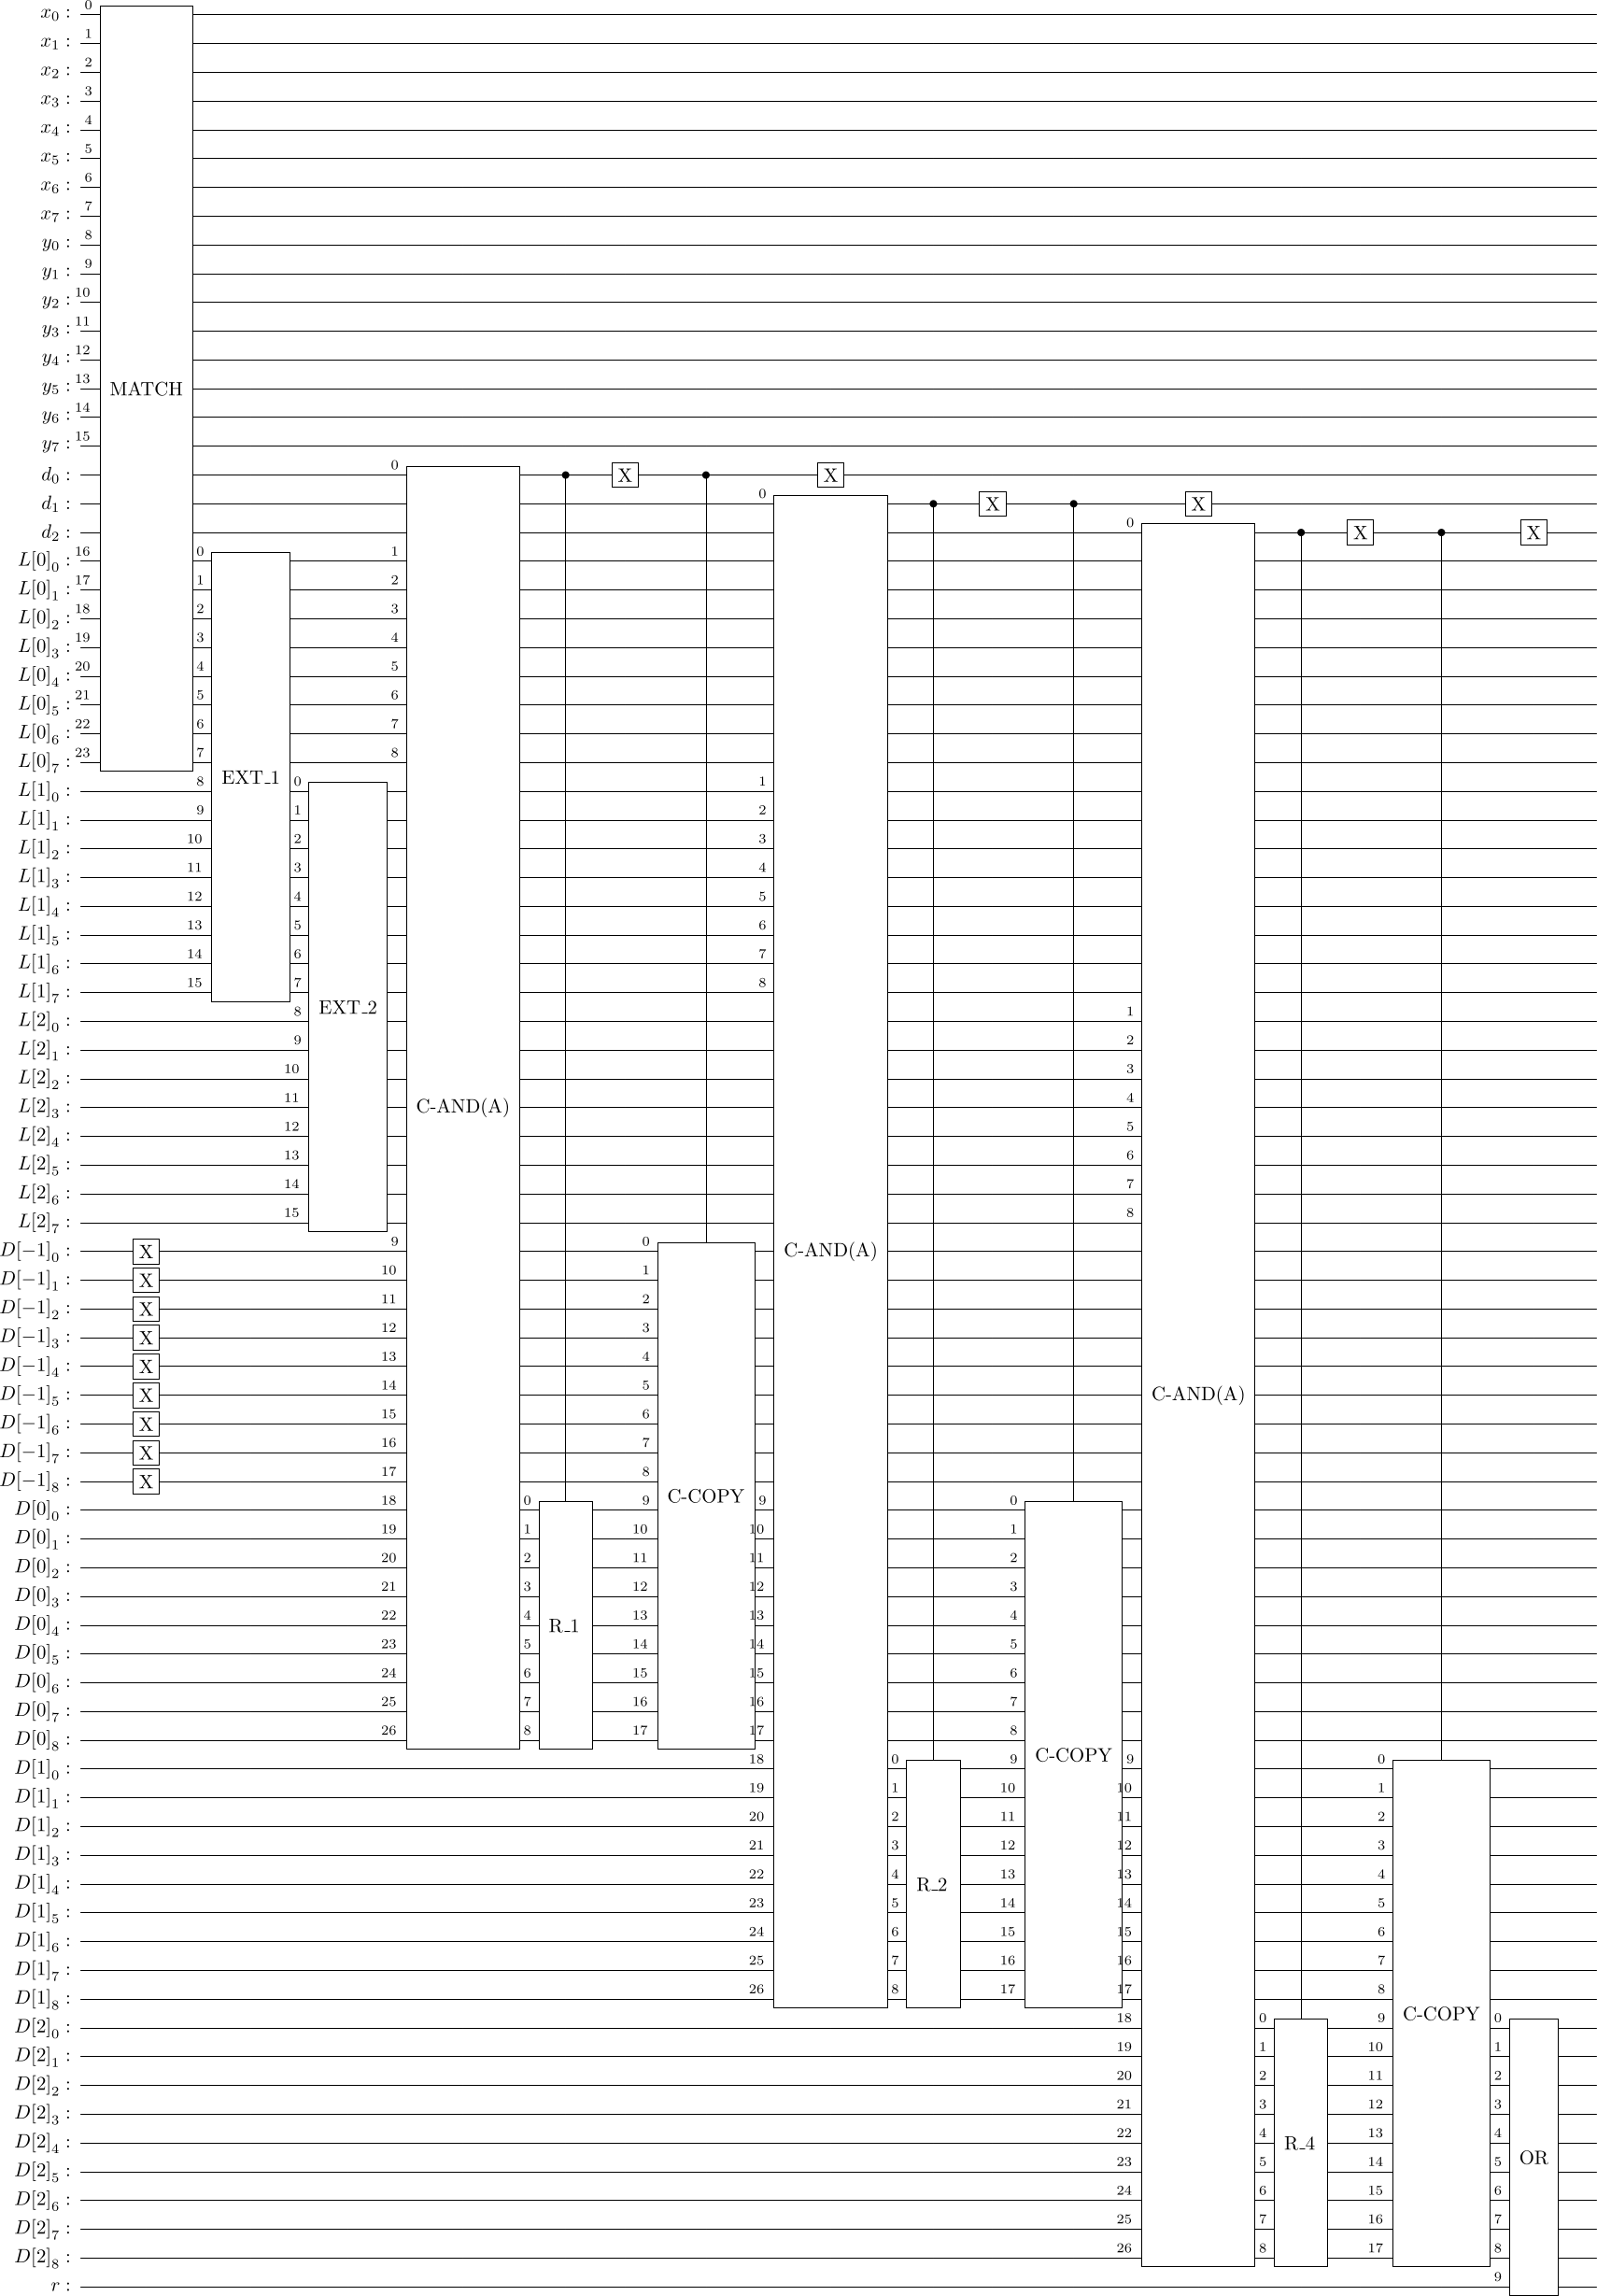

In [58]:
def SFC(n):
    '''
    builds the Fixed Substring Matching operator for inputs of size `n`

    QUBITS NEEDED:
    - `n` qubits for string x
    - `n` qubits for string y
    - `log_2(n)` qubits for string d
    - ancilla qubits
    - 1 result qubit
    '''
    d_len = int(np.ceil(np.log2(n)))
    L_num = d_len
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(n, 'y')
    qd = QuantumRegister(d_len, 'd')
    qD = QuantumRegister(d_len+1, 'D')
    qL = []

    for i in range(L_num): # padding
        qL.append(QuantumRegister(n, 'L['+str(i)+']'))
    
    qD = []
    for i in range(d_len+1):
        qD.append(QuantumRegister(n+1, 'D['+str(i-1)+']'))
    
    qr = QuantumRegister(1, 'r')
    qc = QuantumCircuit(qx,qy,qd,*qL,*qD,qr)
    
    # init
    qc.x(qD[0])
    
    #qc.barrier()

    qc = qc.compose(match_operator(n), [*qx, *qy, *qL[0]])
    
    for i in range(L_num-1):
        qc = qc.compose(extension_operator(n, i+1), [*qL[i][:n], *qL[i+1]])
    
    #qc = qc.compose(updown_swap(d_len), qd)

    
    #qc.barrier()

    
    for i in range(d_len):
        
        qc = qc.compose(contr_bitwise_and_operator(n), [qd[i], *qL[i], *qD[i], *qD[i+1]])
        
        controlled_rot = quantum_rotation(n+1, 2**i).control(1)
        qc = qc.compose(controlled_rot, [qd[i], *qD[i+1]])
        qc.x(qd[i])
        controlled_copy = copy_operator(n+1).control(1)
        qc = qc.compose(controlled_copy, [qd[i],*qD[i], *qD[i+1]])
        qc.x(qd[i])
        
        #qc.barrier()

    qc = qc.compose(or_operator(n+1), [*qD[d_len], qr])

    return qc

qc = SFC(8)
qc.draw('latex')

In [49]:
def grover_operator(n: int):
    '''
    builds the diffusion operator from the grover algorithm
    '''
    qx = QuantumRegister(n, 'x')
    qc = QuantumCircuit(qx)
    
    qc.h(qx)
    qc.x(qx)
    qc.h(qx[n-1])
    qc.mcx(qx[list(range(n-1))], qx[n-1])
    qc.h(qx[n-1])
    qc.x(qx)
    qc.h(qx)

    return qc.to_gate(label='DIFFUSION')

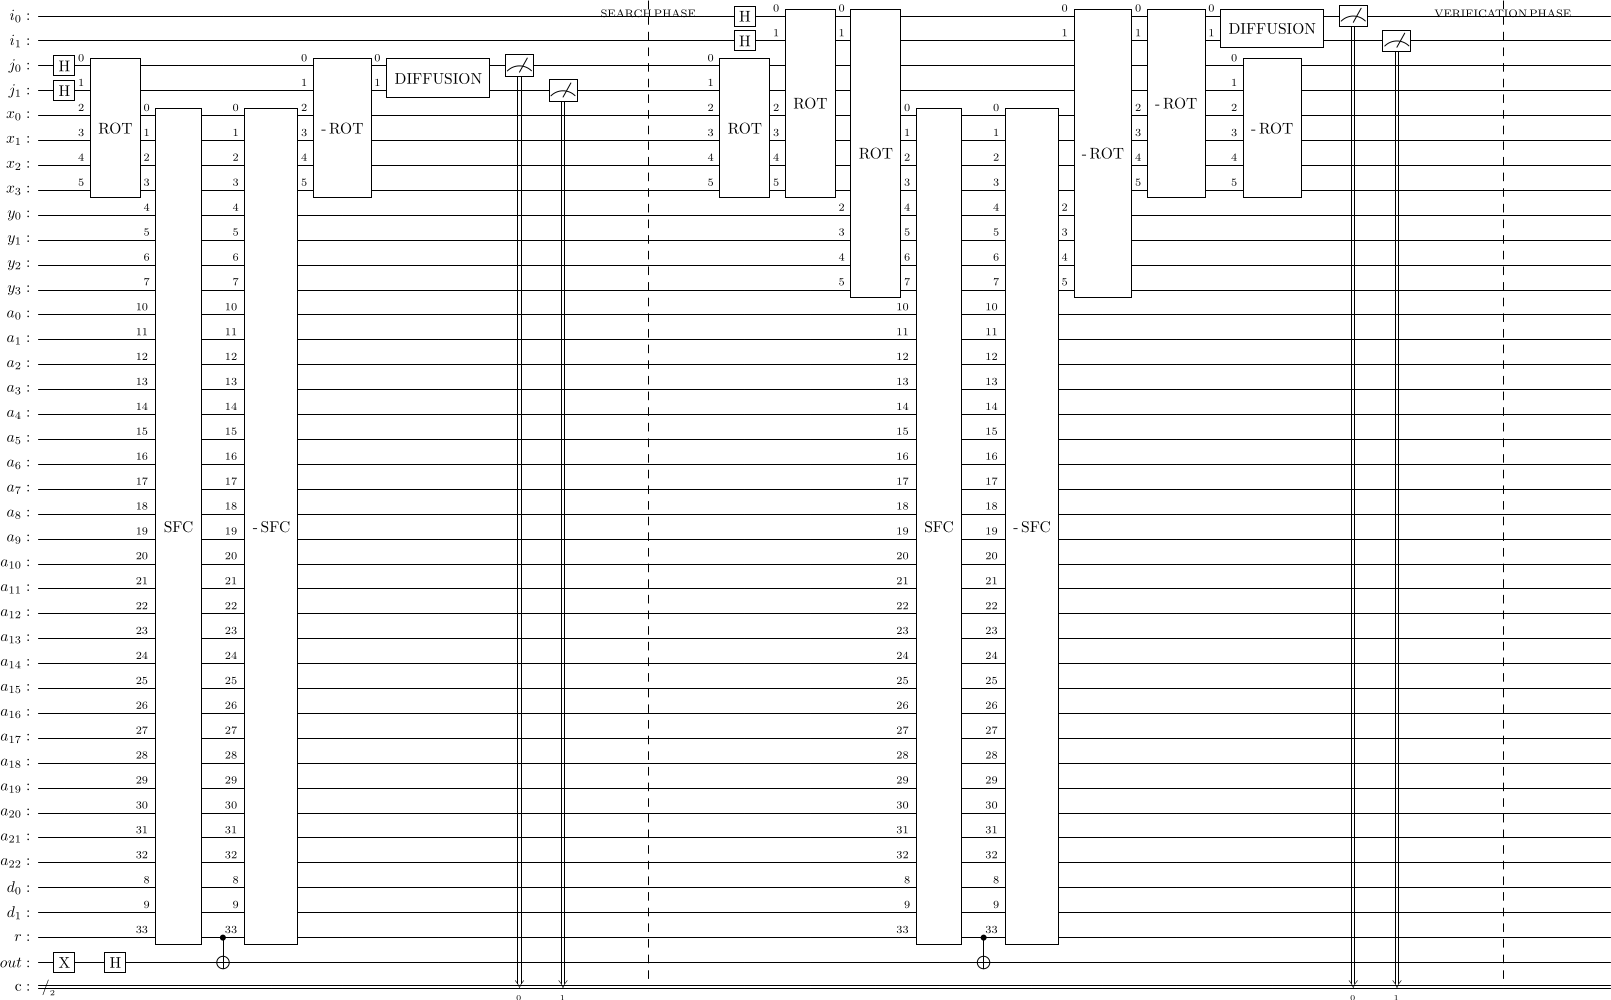

In [78]:
def quantum_step(n: int):

    qi_amount = int(np.ceil(np.log2(n)))
    qi = QuantumRegister(qi_amount, 'i')
    qj = QuantumRegister(qi_amount, 'j')
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(n, 'y')
    ancilla_amount = n * int(np.ceil(np.log2(n))) + (n+1)*(int(np.ceil(np.log2(n)))+1)
    qa = QuantumRegister(ancilla_amount, 'a')
    qd = QuantumRegister(qi_amount, 'd')
    qr = QuantumRegister(1, 'r')
    qo = QuantumRegister(1, 'out')

    c = ClassicalRegister(qi_amount,'c')
    qc = QuantumCircuit(qi,qj,qx,qy,qa,qd,qr,qo, c)


    qc.x(qo)
    qc.h(qo)
    # search phase
    
    qc.h(qj)
    
    epochs = int(np.floor(np.pi/4 * np.sqrt(n)))
    
    for e in range(epochs):
        qc = qc.compose(quantum_controlled_rotation(n).to_gate(label='ROT'), [*qj,*qx])
        qc = qc.compose(SFC(n).to_gate(label='SFC'), [*qx, *qy, *qd, *qa, qr])

        qc.cx(qr, qo)
        qc = qc.compose(SFC(n).inverse().to_gate(label='- SFC'), [*qx, *qy, *qd, *qa, qr])
        qc = qc.compose(quantum_controlled_rotation(n).inverse().to_gate(label='- ROT'), [*qj,*qx])

        qc = qc.compose(grover_operator(qi_amount), qj)

    qc.measure(qj, c)
    qc.barrier(label='SEARCH PHASE')

    qc.h(qi)
    
    epochs = int(np.floor(np.pi/4 * np.sqrt(n)))
    
    for e in range(epochs):
        qc = qc.compose(quantum_controlled_rotation(n).to_gate(label='ROT'), [*qj,*qx])
        qc = qc.compose(quantum_controlled_rotation(n).to_gate(label='ROT'), [*qi,*qx])
        qc = qc.compose(quantum_controlled_rotation(n).to_gate(label='ROT'), [*qi,*qy])
        qc = qc.compose(SFC(n).to_gate(label='SFC'), [*qx, *qy, *qd, *qa, qr])

        qc.cx(qr, qo)
        qc = qc.compose(SFC(n).inverse().to_gate(label='- SFC'), [*qx, *qy, *qd, *qa, qr])
        qc = qc.compose(quantum_controlled_rotation(n).inverse().to_gate(label='- ROT'), [*qi,*qy])
        qc = qc.compose(quantum_controlled_rotation(n).inverse().to_gate(label='- ROT'), [*qi,*qx])
        qc = qc.compose(quantum_controlled_rotation(n).inverse().to_gate(label='- ROT'), [*qj,*qx])

        qc = qc.compose(grover_operator(qi_amount), qi)

    qc.measure(qi, c)
    qc.barrier(label='VERIFICATION PHASE')

    return qc

quantum_step(4).draw('latex', scale=0.75)

In [65]:
run(quantum_step(4))

{'0': 1024}